### Johdanto datatieteeseen
# Tampereen kaksiot

Tämän notebookin tarkoituksena on raapia dataa Tampereen kaksioista Etuovi.com -sivustolta, siistiä sitä, tunnistaa merkittävät ominaisuudet, sekä luoda pari erilaista regressiomallia sen pohjalta. Ratkaistavia esimerkkiongelmiani ovat:
* Regressio-ongelma: Olen myymässä omistusasuntoa Tampereella, enkä tiedä millaisessa hintaluokassa asuntoni kaltaiset kohteet pyörii.

* Luokitteluongelma: Olen etsimässä uutta omistusasuntoa Tampereelta, ja haluaisin tietää mistä päin kaupunkia voisin löytää haluamani kaltaisen asunnon.

## Tarvittavat kirjastot

In [1]:
# Tarvittavien kirjastojen tuominen.
from bs4 import BeautifulSoup as bs
from IPython.display import clear_output
from requests import get
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2, SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, classification_report
from xgboost import XGBRegressor, XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time, os

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
current_time = time.time()

le = LabelEncoder()

print('Done importing')

Done importing


## Datan raapiminen

In [2]:
# Raapimiseen tarvittavien taustatietojen hakeminen, ja määrittäminen.
fileName = 'tampere_kaksiot_etuovi.csv'
headers = ({'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
baseUrl = 'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1481024326&sivu='
html = get(baseUrl, headers=headers)
soup = bs(html.text, 'html.parser')

houseCards = soup.find_all('div', class_="ListPage__cardContainer__39dKQ")
tabs = soup.find_all('button', class_="theme__button__1YqFK theme__flat__13aFK theme__button__1YqFK theme__squared__17Uvn theme__neutral__1F1Jf Button__button__3K-jn Pagination__button__3H2wX")
max_tab = int(tabs[-1].contents[0])

In [3]:
# Datan raavinta. Jos raavittu csv-tiedosto löytyy, käytetään sitä.
if fileName in os.listdir('./data/'):
    df = pd.read_csv(f'./data/{fileName}', index_col=0)
    print('Local data found! Imported to DataFrame.')
else:
    loadingBar = []
    limit = 0.1
    data = {
    'Alue': [],
    'Osoite': [],
    'Hinta': [],
    'Koko': [],
    'Vuosi': [],
    'Talotyyppi': [],
    'Sauna': [],
    'Parveke': [],
    }

    for i in range(max_tab):
        clear_output(wait=True)

        baseUrl = f'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1481187938&sivu={i+1}'
        html = get(baseUrl, headers=headers)
        soup = bs(html.text, 'html.parser')

        houseCards = soup.find_all('div', class_="ListPage__cardContainer__39dKQ")

        for temp in houseCards:
            spans = temp.find_all('span', class_='')

            isSize = False
            isPrice = False
            isYear = False

            for item in spans:
                if isPrice:
                    price = item.contents[0].replace('\xa0', '')[:-1]
                    price = float(price.replace(',','.'))
                    isPrice = False
                elif isSize:
                    try:
                        size = float(item.contents[0].replace(',', '.'))
                    except ValueError:
                        size = None
                    isSize = False
                elif isYear:
                    try:
                        year = int(item.contents[0])
                    except ValueError:
                        year = None
                    isYear = False
                else:

                    if 'Hinta' in item.contents and 'Hintamuutos' not in item.contents:
                        isPrice = True
                    elif 'Koko' in item.contents:
                        isSize = True
                    elif 'Vuosi' in item.contents:
                        isYear = True

            raw_address = temp.find('h4').contents[0]
            try:
                address, area, city_ = raw_address.split(', ') # Osoite, Alue
            except ValueError:
                address, city = raw_address.split(', ')
                if 'Opiskelijankatu' in address:
                    area = 'Hervanta'

            raw_type = temp.find('h5').contents[0]
            try:
                house_type, raw_attributes = raw_type.split(' | ') # Talotyyppi
                attributes = raw_attributes.split(' + ') # Ominaisuudet
            except ValueError:
                house_type = raw_type


            data['Alue'].append(area)
            data['Osoite'].append(address)
            data['Hinta'].append(price)
            data['Koko'].append(size)
            data['Vuosi'].append(year)
            data['Talotyyppi'].append(house_type)
            if 's' in attributes:
                sauna = True
            else:
                sauna = False
            if 'p' in attributes:
                balcony = True
            else:
                for item in attributes:
                    if 'parveke' in item:
                        balcony = True
                else:
                    balcony = False

            data['Sauna'].append(sauna)
            data['Parveke'].append(balcony)
        
        if i/max_tab >= limit:
            loadingBar.append('#')
            limit += 0.1
        print('{}{:10}{}'.format('|', ''.join(loadingBar), '|'),'Scraping data...')
        
    df = pd.DataFrame(data)
    df.to_csv('./data/tampere_kaksiot_etuovi.csv')
    print('Done scraping')

Local data found! Imported to DataFrame.


Nyt raavittu data on käytettävissä pandas-kirjaston hyödyllisessä DataFrame -taulukkoformaatissa. Nyt voidaan jatkaa datan tarkasteluun ja siistimiseen.


## Datan tarkastelu ja siistiminen

In [4]:
df.head()

,Alue,Osoite,Hinta,Koko,Vuosi,Talotyyppi,Sauna,Parveke
0,Multisilta,Kitiniitynkatu 9-11 H,105000.0,62.0,1971.0,Kerrostalo,False,False
1,Armonkallio,Siltakatu 8 C,197000.0,56.0,1932.0,Kerrostalo,False,False
2,Amuri,Satakunnankatu 33 A,267000.0,49.5,2017.0,Kerrostalo,False,False
3,Hervanta,Laattapolku 3,149000.0,49.0,1990.0,Kerrostalo,True,True
4,Hatanpää,Siirtolapuutarhankatu 13,179000.0,49.0,2003.0,Kerrostalo,False,False


In [5]:
# Tilastollisia tietoja datan numeerisista muuttujista
df.describe()

,Hinta,Koko,Vuosi
count,912.000000,911.000000,911.000000
mean,214610.507840,48.026345,2008.491767
std,84661.087016,9.356647,22.776064
min,0.000000,29.000000,1920.000000
25%,155000.000000,40.500000,2012.000000
50%,199700.000000,47.500000,2020.000000
75%,251810.000000,54.500000,2021.000000
max,708550.000000,93.500000,2022.000000


In [6]:
# Tietoja datasarakkeiden määristä ja tyypeistä
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912 entries, 0 to 911
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Alue        912 non-null    object 
 1   Osoite      912 non-null    object 
 2   Hinta       912 non-null    float64
 3   Koko        911 non-null    float64
 4   Vuosi       911 non-null    float64
 5   Talotyyppi  912 non-null    object 
 6   Sauna       912 non-null    bool   
 7   Parveke     912 non-null    bool   
dtypes: bool(2), float64(3), object(3)
memory usage: 51.7+ KB


Viimeisimmän komennon tulosteesta voidaan nähdä joissakin sarakkeissa olevan puuttuvia arvoja (22.4.2020). Korvataan puuttuvat numeeriset arvot aluekohtaisilla keskiarvoilla.

In [7]:
colsWithNan = df.columns[df.isna().any()].tolist()
for col in colsWithNan:
    df[col].fillna(round(df[col].mean()), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912 entries, 0 to 911
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Alue        912 non-null    object 
 1   Osoite      912 non-null    object 
 2   Hinta       912 non-null    float64
 3   Koko        912 non-null    float64
 4   Vuosi       912 non-null    float64
 5   Talotyyppi  912 non-null    object 
 6   Sauna       912 non-null    bool   
 7   Parveke     912 non-null    bool   
dtypes: bool(2), float64(3), object(3)
memory usage: 51.7+ KB


Nyt puuttuvia arvoja ei enää ole. Visualisoidaan seuraavaksi hiukan datan sisältöä.

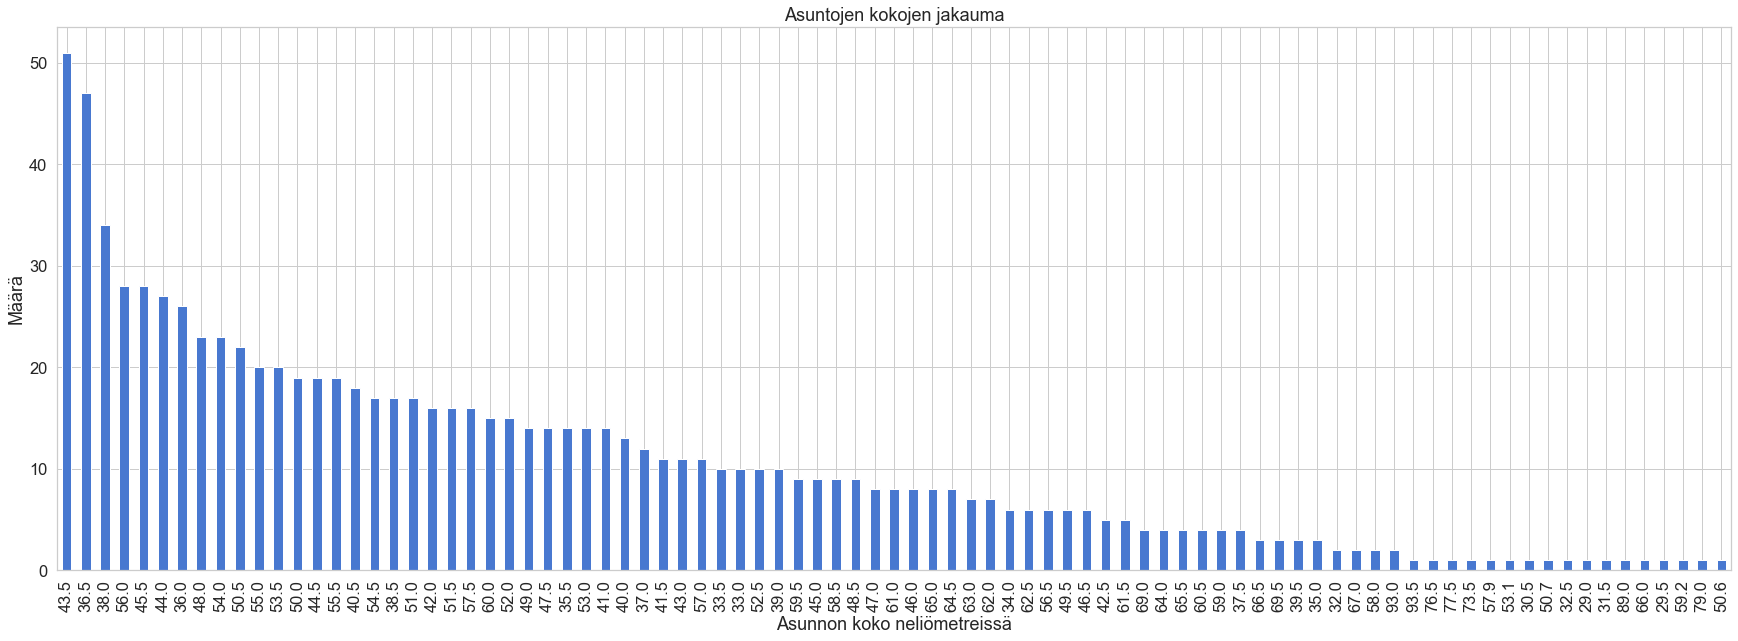

In [8]:
plt.figure(figsize=(30,10))
plt.title('Asuntojen kokojen jakauma')
plt.xlabel('Asunnon koko neliömetreissä')
plt.ylabel('Määrä')
df['Koko'].value_counts().plot(kind='bar');

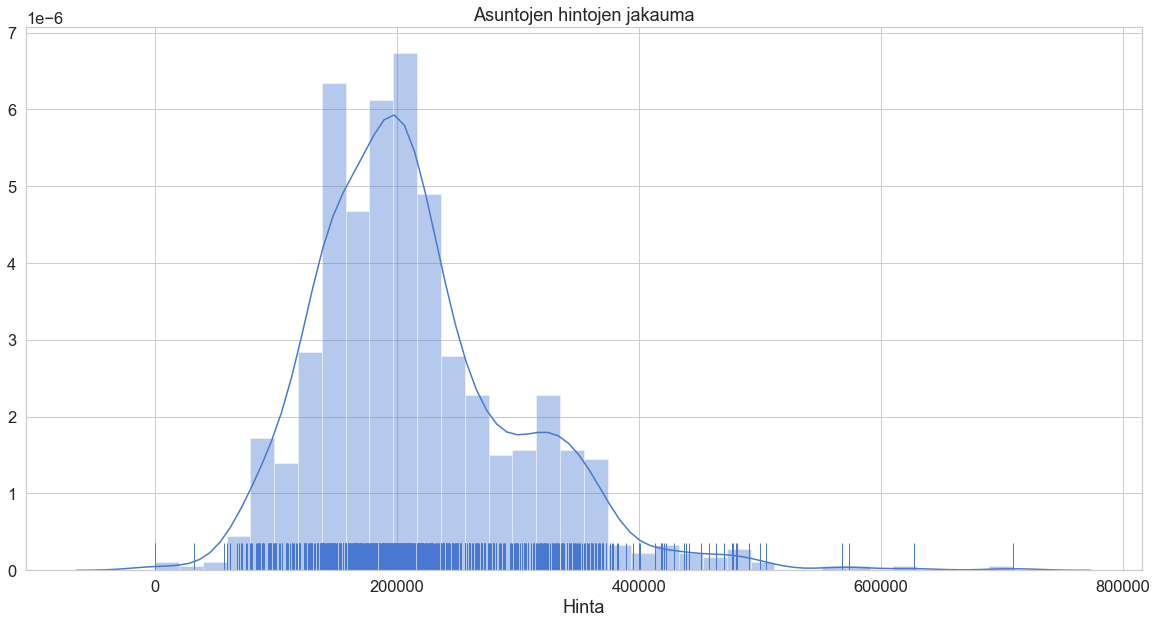

In [9]:
plt.figure(figsize=(20,10))
plt.title('Asuntojen hintojen jakauma')
sns.distplot(df['Hinta'], rug=True);

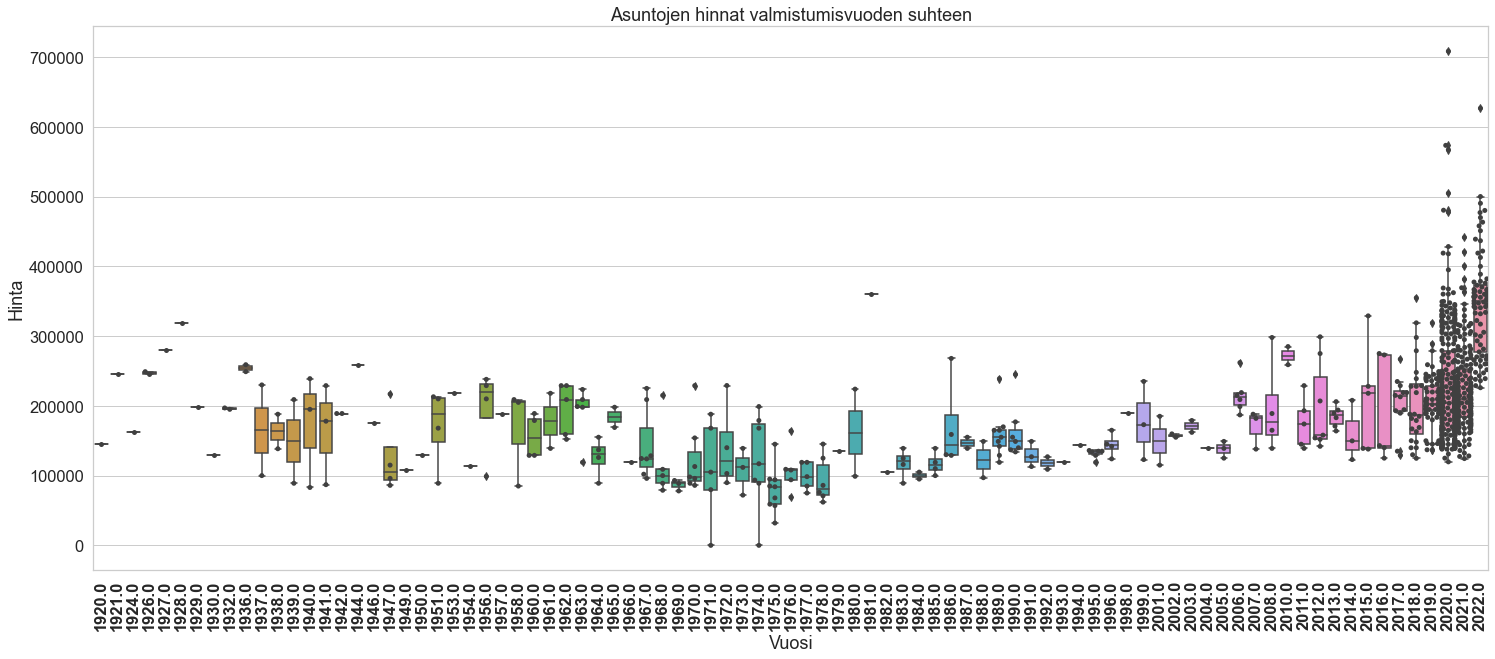

In [10]:
plt.figure(figsize=(25,10))

sns.boxplot(x='Vuosi', y="Hinta", data=df,)
sns.swarmplot(x='Vuosi', y="Hinta", data=df, color=".25",)
plt.title('Asuntojen hinnat valmistumisvuoden suhteen');
plt.xticks(weight='bold',rotation=90,);

## Oleellisten piirteiden tunnistaminen

Aloitetaan korvaamalla kategoriset muuttujat numeerisilla korvikkeilla.

In [11]:
print('Before\n', df.dtypes)
fits = {}
for col in df.columns:
    if df[col].dtype == 'object' and col != 'Osoite':
        newColName = f'{col}_'
        fit = le.fit(df[col])
        fits[newColName] = fit
        df[newColName] = fit.transform(df[col])
print('\nAfter\n', df.dtypes)
#e_df = pd.get_dummies(df, prefix=['_'], columns=['Alue'])

Before
 Alue           object
Osoite         object
Hinta         float64
Koko          float64
Vuosi         float64
Talotyyppi     object
Sauna            bool
Parveke          bool
dtype: object

After
 Alue            object
Osoite          object
Hinta          float64
Koko           float64
Vuosi          float64
Talotyyppi      object
Sauna             bool
Parveke           bool
Alue_            int32
Talotyyppi_      int32
dtype: object


### Korrelaatioanalyysi

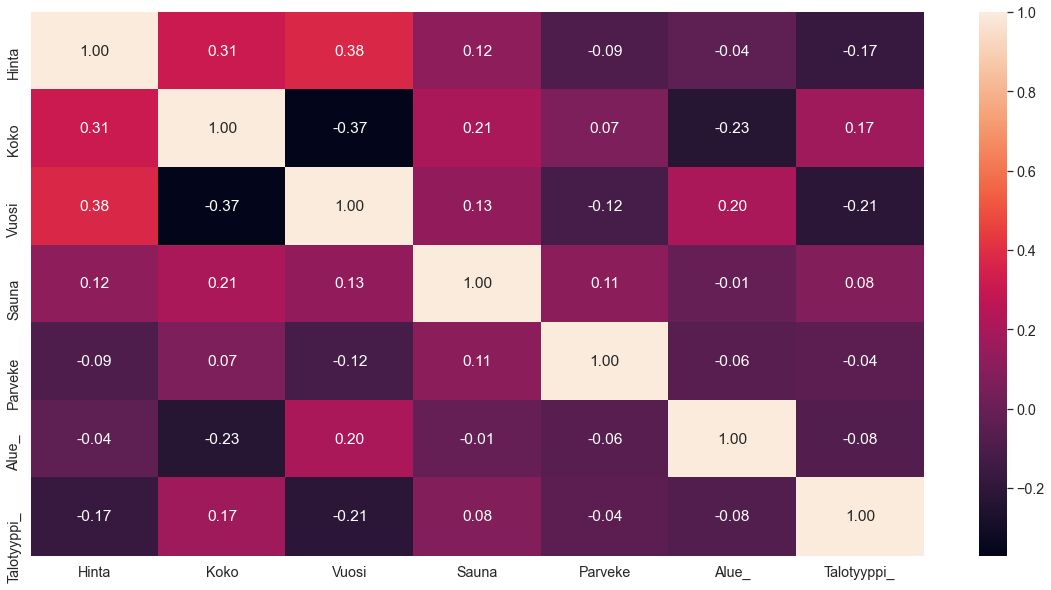

In [13]:
sns.set(font_scale=1.3)
correlation_df = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(correlation_df,annot=True,fmt='.2f');

Erotellaan listaan korrelaatiot, jotka ovat suurempia kuin 0.1 ja pienempiä kuin 0.8, tai pienempiä kuin -0.1.

In [31]:
corr_dict=correlation_df['Hinta'].sort_values(ascending=False).to_dict()
important_cols=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<0.8)) | (value<=-0.1):
        print(key, round(value,5))
        important_cols.append(key)

Vuosi 0.3789
Koko 0.31386
Sauna 0.1172
Talotyyppi_ -0.16759


Sarakkeiden korrelaatiot eivät tällä hetkellä ole kovin vahvoja, mutta valmistumisvuosi näyttäisi korreloivan eniten hinnan kanssa.

### Chi2-analyysi

Kokeillaan erotella tärkeitä piirteitä sklearn-kirjastoon sisältyvällä SelectKBest-funktion avulla.

In [15]:
y = df.Hinta.astype('int')
X = df.drop(['Hinta', 'Alue', 'Osoite', 'Talotyyppi'], axis=1)

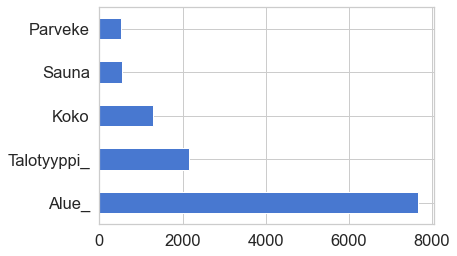

In [16]:
kbest = SelectKBest(score_func=chi2, k=len(X.columns))
kbest.fit(X,y)

feat_score = pd.Series(kbest.scores_, index=X.columns)
feat_score.nlargest().plot(kind='barh');

Tämän testin perusteella asunnon koko olisi tärkeä piirre. 

#### ExtraTreesClassifier -testi
Tämä testi pohjautuu sklearn-kirjaston ExtraTreesClassifier-funktioon. Se muodostaa sarakkeille tärkeyskertoimia, jolloin suurempi arvo on merkki tärkeämmästä piirteestä.

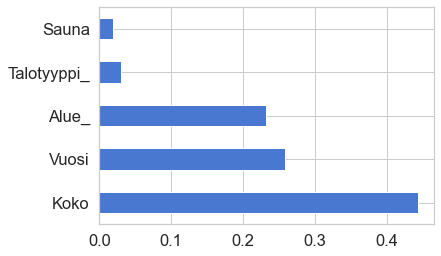

In [17]:
model = ExtraTreesClassifier()
model.fit(X,y)
#print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest().plot(kind='barh');

Tämänkin testin perusteella asunnon koko olisi tärkein piirre.

Testien perusteella asunnon koko olisi siis tärkein piirre hinnan suhteen. Otetaan malleihin mukaan myös testeissä toiseksi tulleet asuntojen koot.

Tarkastellaan eri piirteiden suhteita hintaan vielä visuaalisesti.

<Figure size 2160x1440 with 0 Axes>

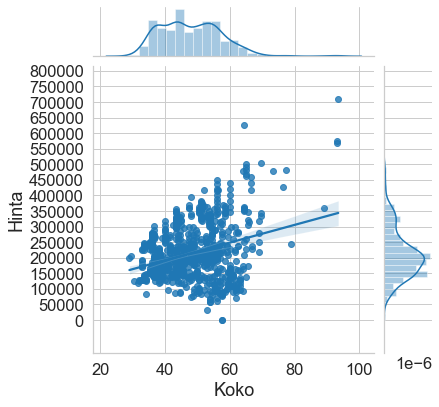

<Figure size 2160x1440 with 0 Axes>

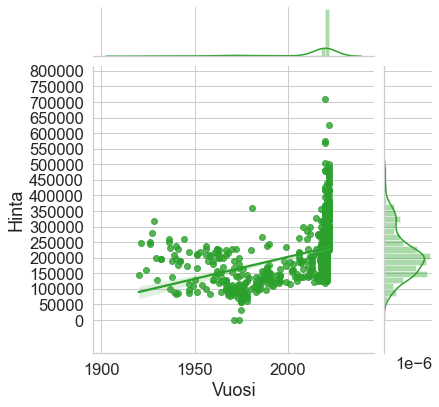

<Figure size 2160x1440 with 0 Axes>

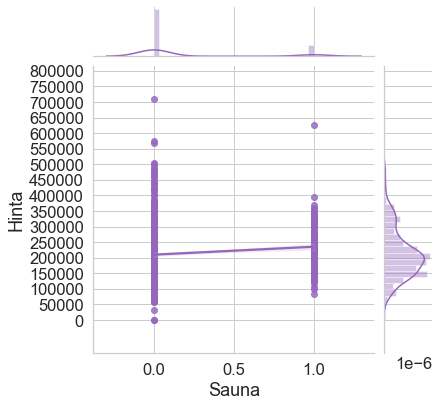

<Figure size 2160x1440 with 0 Axes>

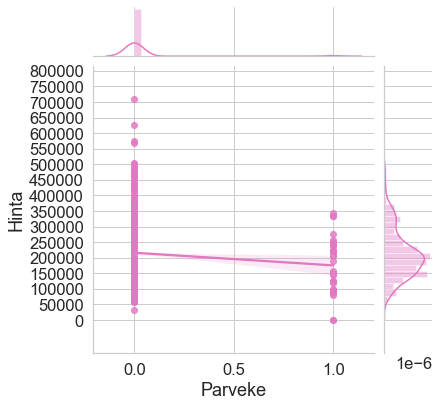

<Figure size 2160x1440 with 0 Axes>

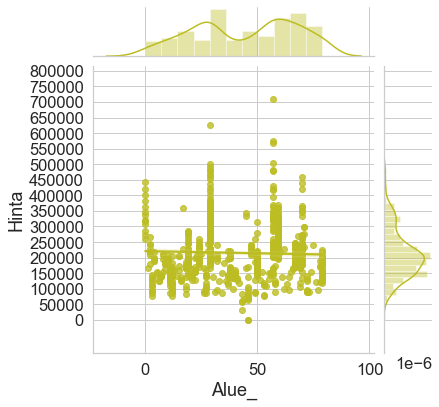

<Figure size 2160x1440 with 0 Axes>

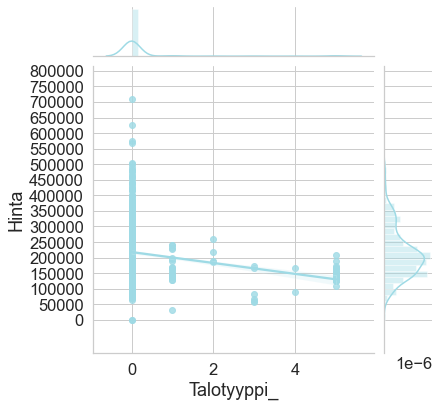

In [18]:
colors=[plt.cm.tab20(each) for each in np.linspace(0, 1, len(X.columns))];
for i,c in zip(X,colors):
    plt.style.use('seaborn-dark-palette');
    plt.figure(figsize=(30,20));
    sns.jointplot(x=i, y='Hinta', data=df, kind="reg",color=c);
    plt.xlabel(str(i));
    plt.yticks(np.arange(0,800001,50000));

## Mallien muodostaminen
### Regressiomallit

In [20]:
y = df.Hinta
#X = encoded_df.drop('Hinta', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

#### sklearn

In [21]:
time_start = time.time()

regr = LinearRegression()
regr.fit(X_train, y_train)

train_result = regr.predict(X_train)
test_result = regr.predict(X_test)

time_end = time.time()

rmse_train = mean_squared_error(y_train, train_result, squared=False)
r2_train = r2_score(y_train, train_result)

rmse_test = mean_squared_error(y_test, test_result, squared=False)
r2_test = r2_score(y_test, test_result)

print(f"Time taken to run: {round(time_end - time_start, 4)} seconds")
print("\nTraining RMSE:", round(rmse_train,4))
print("Testing RMSE:", round(rmse_test,4))
print("\nTraining R2:", round(r2_train,4))
print("Testing R2:", round(r2_test,4))

Time taken to run: 0.029 seconds

Training RMSE: 64744.8369
Testing RMSE: 66390.8936

Training R2: 0.3823
Testing R2: 0.4528


#### XGBoost

In [23]:
time_start = time.time()

regr = XGBRegressor()
regr.fit(X_train, y_train)

train_result = regr.predict(X_train)
test_result = regr.predict(X_test)

time_end = time.time()

rmse_train = mean_squared_error(y_train, train_result, squared=False)
r2_train = r2_score(y_train, train_result)

rmse_test = mean_squared_error(y_test, test_result, squared=False)
r2_test = r2_score(y_test, test_result)

print(f"Time taken to run: {round(time_end - time_start, 4)} seconds")
print("\nTraining RMSE:", round(rmse_train,4))
print("Testing RMSE:", round(rmse_test,4))
print("\nTraining R2:", round(r2_train,4))
print("Testing R2:", round(r2_test,4))

Time taken to run: 0.2019 seconds

Training RMSE: 10617.5389
Testing RMSE: 31004.0112

Training R2: 0.9834
Testing R2: 0.8807


In [24]:
ft_weights = pd.DataFrame(regr.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights.sort_values('weight', ascending=False, inplace=True)
ft_weights.head(len(X_train.columns))

,weight
Vuosi,0.404337
Alue_,0.220702
Koko,0.199591
Talotyyppi_,0.092996
Sauna,0.041285
Parveke,0.041089


### Luokittelumallit

In [28]:
y = le.fit_transform(df.Alue)
X_clf = df.drop(['Alue', 'Osoite', 'Talotyyppi', 'Alue_'], axis=1)

#y = l_encoder.fit_transform(y) 

X_train, X_test, y_train, y_test = train_test_split(X_clf, y, random_state=5)
', '.join(X_clf.columns)

'Hinta, Koko, Vuosi, Sauna, Parveke, Talotyyppi_'

#### RandomForestClassifier

In [29]:
rf_clf = RandomForestClassifier()
clf.fit(X_train, y_train, )
result = clf.predict(X_test)
print ('Confusion Matrix :') 
print(confusion_matrix(y_test, result)) 
print ('Accuracy Score :',accuracy_score(y_test, result)) 
print ('Report : ') 
print (classification_report(y_test, result)) 

Confusion Matrix :
[[ 4  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  1  1]
 [ 0  0  0 ...  0  0 20]]
Accuracy Score : 0.706140350877193
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.00      0.00      0.00         0
           2       0.33      0.33      0.33         3
           3       0.25      0.50      0.33         2
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         3
          11       1.00      1.00      1.00         3
          12       0.17      0.33      0.22         3
          15       0.50      0.50      0.50         2
          16       1.00      0.50      0.67         2
          18       1.00

In [ ]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest().plot(kind='barh');

#### XGBClassifier

In [33]:
xgb_clf = XGBClassifier()
clf.fit(X_train, y_train, )
result = clf.predict(X_test)
print ('Confusion Matrix :') 
print(confusion_matrix(y_test, result)) 
print ('Accuracy Score :',accuracy_score(y_test, result)) 
print ('Report : ') 
print (classification_report(y_test, result)) 

Confusion Matrix :
[[ 4  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  1]
 [ 0  0  0 ...  0  0 20]]
Accuracy Score : 0.6491228070175439
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           2       0.50      0.33      0.40         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         0
          11       0.50      0.67      0.57         3
          12       0.14      0.33      0.20         3
          15       1.00      0.50      0.67         2
          16       0.00      0.00      0.00         2
          18       0.67      1.00      0.80         6
          19       0.3

In [ ]:
feat_importances = pd.Series(xgb_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest().plot(kind='barh');

### Mallien testaus

In [ ]:
test_values = {
    'Hinta': [1078500],
    'Koko': [50],
    'Vuosi': [2000],
    'Sauna': [1],
    'Parveke': [1],
    'Talotyyppi_': [0]
}

test_values = pd.DataFrame(test_values)

In [34]:
rf_result = clf.predict(test_values)
print('RandomForests prediction: ',', '.join(le.inverse_transform(rf_result)))

xgb_result = clf.predict(test_values)
print('XGBs prediction: ',', '.join(le.inverse_transform(xbg_result)))

'Tampella'

## Hyödyllisiä lähteitä
Data
* https://www.etuovi.com/myytavat-asunnot/tampere

Mallit
* https://www.geeksforgeeks.org/regression-classification-supervised-machine-learning/

Ominaisuuksien erittely
* https://scikit-learn.org/stable/modules/feature_selection.html
* https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
* https://www.kaggle.com/darkside92/detailed-examination-for-house-price-top-10

Raapiminen
* https://towardsdatascience.com/looking-for-a-house-build-a-web-scraper-to-help-you-5ab25badc83e

XGB
* https://github.com/gracecarrillo/Predicting-Airbnb-prices-with-machine-learning-and-location-data/blob/gh-pages/Exploring_Edinburgh_Graciela_Carrillo.ipynb



## Helpot ja vaikeat asiat
* Koodauksen kannalta homma oli joissain määrin tuttua, joten tekninen puoli sujui aika huomaamatta joitain ongelmakohtia lukuunottamatta
* 